<span class='main_title'>Unstructured Data Final Project</span>
<hr>
<span class='author'>author:<a href='github.com/baiochi'>@baiochi<span>

**Description**  
Create a solution with <a href='https://google.github.io/mediapipe/'>`MediaPipe`</a> library for detect Sign language through a Webcam.  

# Notebook Setup

## Aesthetics

In [1]:
# Terminal ASCII colors
WHITE = '\033[39m'
CYAN  = '\033[36m'
GREEN = '\033[32m'

# Image drawing colors
BLUE   = '#00fafd'    # rgb(0,250,253)
YELLOW = '#f5b324'    # rgb(245,179,36)

# Display images in Jupyter Notebook
from IPython.display import Image

# Styling notebook with CSS
from IPython.core.display import HTML
styles = open("./styles/custom.css", "r").read()
HTML(styles)

## Libraries

In [2]:
# Supress warnings
import warnings; warnings.filterwarnings('ignore')

# Data and math operations
import re
from math import hypot, atan2, degrees
import numpy as np
import pandas as pd

# Compute DTW distance
from scipy.spatial.distance import euclidean
from scipy.stats import uniform
from fastdtw import fastdtw

# Image processing
import cv2
import mediapipe as mp

# Image visualizations
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
import plotly.graph_objects as go

# Audio Speech
import pyttsx3

# For opening images via URL
from PIL.Image import open as open_image
from urllib.request import urlopen

# Read mediapipe labels
from google.protobuf.json_format import MessageToDict

# OS functions
import os
import time

# Progress bar
from tqdm.auto import tqdm

## Mediapipe Setup

In [3]:
# Mediapipe instances
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# Landmark styles
HAND_CONNECTIONS = mp_hands.HAND_CONNECTIONS
# DEFAULT_LANDMARK_POINTS = mp_drawing_styles.get_default_hand_landmarks_style()
# DEFAULT_LANDMARK_CONNECTIONS = mp_drawing_styles.get_default_hand_connections_style()
LANDMARK_DRAWING_SPECS = mp_drawing.DrawingSpec(
        color=(36, 179, 245), 
        thickness=1, 
        circle_radius=4
)
CONNECTIONS_DRAWING_SPECS=mp_drawing.DrawingSpec(
        color=(253, 250, 0), 
        thickness=2, 
        circle_radius=5
)
FONT_ARGS = {
    'fontFace'  : cv2.FONT_HERSHEY_SIMPLEX,
    'fontScale' : 1,
    'color'     : (253, 250, 0),
    'thickness' : 2,
    'lineType'  : cv2.LINE_AA
}
LETTER_ARGS = {
    'fontFace'  : cv2.FONT_HERSHEY_SIMPLEX,
    'fontScale' : 3,
    'color'     : (0, 250, 253),
    'thickness' : 2,
    'lineType'  : cv2.LINE_AA
}

In [4]:
# Mapping of handpoints
_hand_point_names = [ 
                     ['THUMB_'         + i for i in ['CMC','MCP','IP','TIP']],
                     ['INDEX_FINGER_'  + i for i in ['MCP','PIP','DIP','TIP']],
                     ['MIDDLE_FINGER_' + i for i in ['MCP','PIP','DIP','TIP']],
                     ['RING_FINGER_'   + i for i in ['MCP','PIP','DIP','TIP']],
                     ['PINKY_'         + i for i in ['MCP','PIP','DIP','TIP']]
                    ]
_hand_point_names  = ['WRIST'] + [value for sublist in _hand_point_names for value in sublist]

HAND_POINT_MAPPING = {index:_hand_point_names[index] for index in range(21)}

def create_mapping(landmark_results:list) -> dict:
    '''
    Map every position with the respective name
    Example: 0 -> 'WRIST'; 1 -> 'THUMB_CMC' etc
    '''
    _hand_coord = [([i[1], i[2]]) for i in landmark_results]
    hand_map = {
        HAND_POINT_MAPPING[index]: coord for index, coord in enumerate(_hand_coord)}
    return hand_map

Image(url= 'https://google.github.io/mediapipe/images/mobile/hand_landmarks.png', width=600, height=400)

#  Sign Detection Workflow

## Capturing frames with Webcam

In [9]:
def capture_gesture(FRAME_SIZE=60):
    # Create Mediapipe Hands model
    hands = mp_hands.Hands(model_complexity=0, 
                           min_detection_confidence=0.5, 
                           min_tracking_confidence=0.9)
    # Store frames/results
    frame_list = []
    results_list = []

    # Settings
    recording = False

    # Webcam input
    cam = cv2.VideoCapture(0)

    while cam.isOpened():
        # Read frame
        _, image = cam.read()

        # Improve performance -> False
        image.flags.writeable = False
        # Convert image from BGR to RGB
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Detect hands
        results = hands.process(rgb_image)

        # Start "recording"
        if recording:
            # Recording flag
            cv2.putText(image, 'Recording...', (30, 50), **FONT_ARGS)

            if len(frame_list) < FRAME_SIZE:
                frame_list.append(image)
                results_list.append(results)
            else:
                print('Ending recording...')
                recording = False

        # Show image
        cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
        # Key control
        pressed_key = cv2.waitKey(1) & 0xFF
        # Start recording
        if pressed_key == ord('r'):
            recording = True
        # Close webcam
        elif pressed_key == ord('q'):
            recording = False
            break

    # Release video capture
    cam.release()
    # Memory dump
    cv2.destroyAllWindows()
    # fix window not closing bug on macOS 10.15
    cv2.waitKey(1)
    
    return frame_list, results_list

In [10]:
frame_list, results_list = capture_gesture()

Ending recording...


## Draw hand landmarks

In [14]:
def draw_frame_landmarks(frame_list, results_list):
    annot_images = frame_list.copy()

    for frame_number, results in enumerate(results_list):
        if results.multi_hand_landmarks:
            for hand_number, hand_landmark in enumerate(results.multi_hand_landmarks):
                # Draw annotations
                mp_drawing.draw_landmarks(
                            annot_images[frame_number],
                            hand_landmark,
                            HAND_CONNECTIONS,
                            LANDMARK_DRAWING_SPECS,
                            CONNECTIONS_DRAWING_SPECS)
    return annot_images

In [15]:
annot_images = draw_frame_landmarks(frame_list, results_list)

## Plot frames with landmarks

In [21]:
def plot_frames(annot_images):
    fig = plt.figure(figsize=(16,12))
    plt.axis('off')
    plt.title('Example of frames record', size=18, pad=20, loc='left')
    for i, image in enumerate(annot_images[::3]):
        if i == 9:
            break
        fig.add_subplot(3, 3, i+1)
        plt.title(f'Frame {i*3}')
        plt.axis('off')
        # Convert color since matplotlib uses RGB
        plt.imshow(cv2.flip(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1));
        

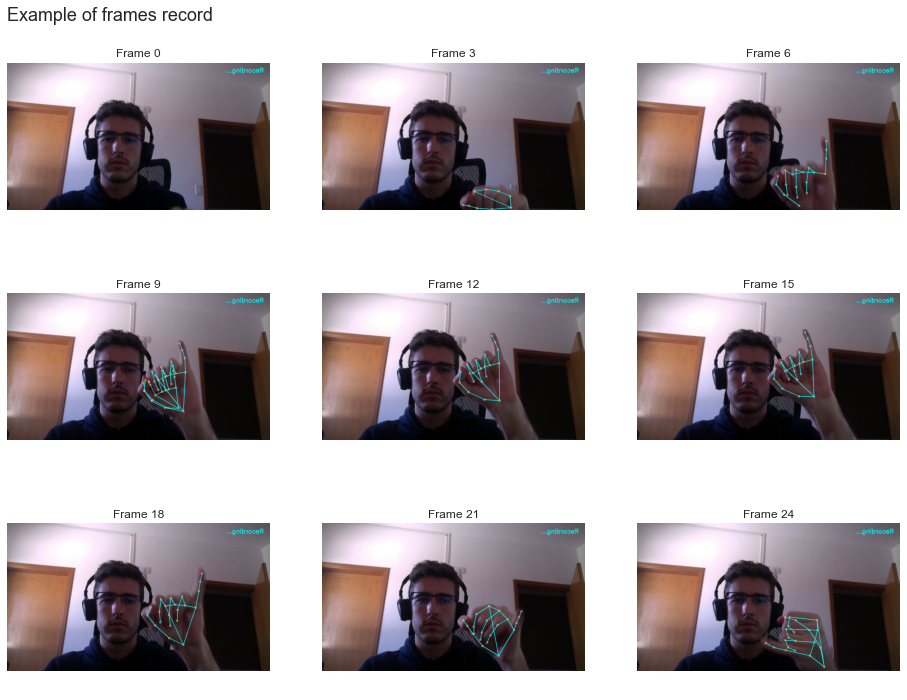

In [22]:
plot_frames(annot_images)

## Process results

**results_list**: contains *mediapipe.python.solution_base.SolutionOutputs*  
> **multi_hand_landmarks**: list of detected hands, 'Right' or 'Left'  
>> **hand_landmark**: list of every node coordinates(x,y,z)  
>>> **landmark**: x,y,z coordinates for the current node

### Store landmark coordinates in `pd.DataFrame`

In [99]:
def process_results(results_list, verbose=False):
    # Store mapping for each hand
    left_hand_list = []
    right_hand_list = []

    # Iterate over results
    for frame_number, results in enumerate(results_list):
        # Check if any hand was detected
        if results.multi_hand_landmarks:

            # Iterate over hands (right or left)
            for hand_number, hand_landmark in enumerate(results.multi_hand_landmarks):

                # Extract hand orientation str
                hand_label = MessageToDict(results.multi_handedness[hand_number])
                hand_label = hand_label['classification'][0]['label']

                # Create dataframe to store node coordinates
                hand_map_df = pd.DataFrame()

                # Iterate over landmarks of current hand
                for node_id, landmark in enumerate(hand_landmark.landmark):
                    # Get coordinates and labels
                    _row = pd.DataFrame(
                            data={
                                'x'          : landmark.x,
                                'y'          : landmark.y,
                                'z'          : landmark.z,
                            }, index=[node_id])
                    # Append row to dataframe
                    hand_map_df = pd.concat([hand_map_df, _row])

                # Add mapping for into the corresponding hand
                if hand_label == 'Left':
                    left_hand_list.append(hand_map_df)
                elif hand_label == 'Right':
                    right_hand_list.append(hand_map_df)
        #print(f'Frame {frame_number}, Left={len(left_hand_list)}, Right={len(right_hand_list)}')
    if verbose:
        print(f'Frames detected:\nLeft hand:{len(left_hand_list)}, Right hand:{len(right_hand_list)}')
    
    return left_hand_list, right_hand_list

In [24]:
left_hand_list, right_hand_list = process_results(results_list, verbose=True)

Frames detected
Left hand:57, Right hand:2


*Obs:* Some frames can detect the same hand twice.

Visualizing `hand_map_df`

In [25]:
left_hand_list[0].head()

,x,y,z
0,0.280703,0.983750,-4.917041e-09
1,0.352957,0.995310,-1.006884e-02
2,0.410691,0.988035,-4.265238e-02
3,0.441878,0.972102,-7.355604e-02
4,0.463674,0.966360,-1.061803e-01


### Calculate hand_landmark angles

**hand_map_df**: dataframe with all landmarks coordinates for a frame  
> **create_hand_gesture**: iterate over a frame_list to get angle for every landmark     
>> **get_landmark_angles** iterate over a hand_map_df to calculate angles  
>>> **calculate_3D_angle** calculate the angle between 2 nodes of 3 dimensions  

In [26]:
def calculate_3D_angle(u:np.ndarray, v:np.ndarray) -> float:
    '''
    Calculate the angle between 2 points with (x,y,z) coordinates
    ang = acos( (x1*x2 + y1*y2 + z1*z2) / sqrt( (x1*x1 + y1*y1 + z1*z1)*(x2*x2+y2*y2+z2*z2) ) )
    Return: angle in radians
    '''
    # Calculate cross product
    dot_product = np.dot(u, v)
    # Calculate vector norm
    norm = np.linalg.norm(u) * np.linalg.norm(v)
    # Calculate angle in radians
    angle = np.arccos(dot_product / norm)
    if np.isnan(angle) or np.isinf(angle):
        angle=0
    return angle

In [27]:
def get_landmark_angles(landmark_df:pd.DataFrame) -> np.ndarray:
    '''
    Dataframe format:
    x	y	z
    0.183309	0.889030	9.577590e-09
    Return: list of shape 441
    '''
    landmark_angles = []
    # Multiply every node with each other, 21 connections * 21 = 441 angles
    for i in range(landmark_df.shape[0]):
        for j in range(landmark_df.shape[0]):
            # Calculate angle between X and Y coordinates
            _node_1 = landmark_df.iloc[i,[1,2]]
            _node_2 = landmark_df.iloc[j,[1,2]]
            landmark_angles.append(calculate_3D_angle(_node_1, _node_2))
    return landmark_angles

In [97]:
def create_hand_gesture(frame_list:list, connections=441, hand_label=''):
    '''
    frame_list: list of pd.Dataframe containing each frame landmark coordinates
    connections(int): number of connected nodes
    Return: array of shape(frame_number, connections) to compute distance
    '''
    # Create empt array
    frame_size = len(frame_list)
    gesture_array = np.zeros([frame_size, connections])
    # Compute angles for each landmark
    for frame_index, landmark in tqdm(enumerate(frame_list), 
                                      desc=f'Calculating {hand_label} landmark angles',
                                      total=frame_size,
                                      colour='#00fafd'):
        gesture_array[frame_index] = get_landmark_angles(landmark)        
    return gesture_array

Calculate angles for each hand:

In [98]:
left_hand_gesture  = create_hand_gesture(left_hand_list, hand_label='left')
right_hand_gesture = create_hand_gesture(right_hand_list, hand_label='right')

Calculating left landmark angles:   0%|          | 0/57 [00:00<?, ?it/s]

Calculating right landmark angles:   0%|          | 0/2 [00:00<?, ?it/s]

## Plot sign time series

In [30]:
# Create dataframe with 3 frames
plot_data = pd.DataFrame(left_hand_gesture).iloc[::10]
# Melt dataframe for plotting with seaborn
plot_data = plot_data.melt(var_name='Connection',
                           value_name='Angle',
                           ignore_index=False)
# Add Frame column
plot_data = plot_data.rename_axis('Frame').reset_index()
# Sort values by Frame
plot_data.sort_values(by=['Frame','Connection'], inplace=True)
plot_data

,Frame,Connection,Angle
0,0,0,0.000000
6,0,1,0.010116
12,0,2,0.043142
18,0,3,0.075523
24,0,4,0.109438
...,...,...,...
2621,50,436,0.068386
2627,50,437,0.060280
2633,50,438,0.034301
2639,50,439,0.011722


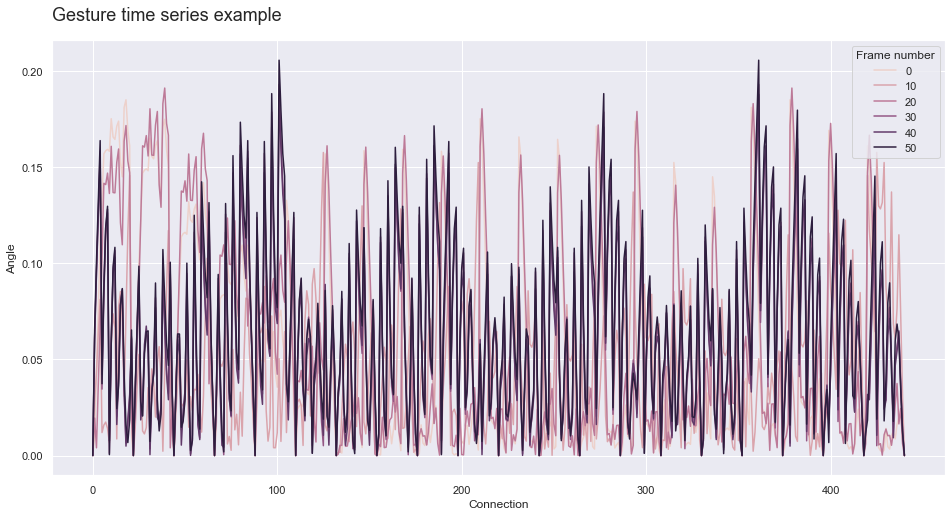

In [31]:
plt.figure(figsize=(16,8))
plt.title('Gesture time series example', size=18, pad=20, loc='left')
sns.lineplot(data=plot_data, x='Connection', y='Angle', hue='Frame')
plt.legend(title='Frame number');

## Load reference Sign

### Read frames from video file

In [94]:
def get_video_frames(file_name):
    
    frame_list = []
    cap = cv2.VideoCapture(file_name)
    pbar = tqdm(desc='Reading frames', total=cap.get(cv2.CAP_PROP_FRAME_COUNT), colour='#f5b324')
    while cap.isOpened():
        # Read frame
        ret, frame = cap.read()
        if not ret:
            pbar.close()
            break
        # Store frame
        frame_list.append(frame)
        pbar.update(1)
    cap.release()
    
    return frame_list

In [53]:
frame_list = get_video_frames('video/11-Libras - J.mp4')

Reading frames: 100%|██████████████████████| 107/107.0 [00:00<00:00, 294.50it/s]


### Process frames with MediaPipe Hands

In [48]:
hands = mp_hands.Hands(model_complexity=0, 
                       min_detection_confidence=0.5, 
                       min_tracking_confidence=0.9)
results_list = []

for frame in tqdm(frame_list, desc='Detecting hands', total=len(frame_list)):
    results_list.append(hands.process(frame))

Detecting hands: 100%|████████████████████████| 107/107 [00:03<00:00, 27.25it/s]


### Get gesture arrays

In [100]:
def process_landmarks(landmarks_results, verbose=False):
    left_hand_gesture=None
    right_hand_list=None
    # Process results
    left_hand_list, right_hand_list = process_results(landmarks_results, verbose)
    # Create gesture arrays
    if len(left_hand_list)>0:
        left_hand_gesture  = create_hand_gesture(left_hand_list, hand_label='left')
    if len(right_hand_list)>0:
        right_hand_gesture  = create_hand_gesture(right_hand_list, hand_label='right')
    
    return left_hand_gesture, right_hand_gesture

In [101]:
reference_left_hand_gesture, reference_right_hand_list = process_landmarks(results_list, True)

Frames detected:
Left hand:54, Right hand:0


Calculating left landmark angles:   0%|          | 0/54 [00:00<?, ?it/s]

## Compute DTW distance

Basic usage of **fastdtw** 
```
x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])

distance, path = fastdtw(x, y, dist=euclidean)
print(distance)
```

Check the distance between `left_hand_gesture` (webcam recorded) and `reference_left_hand_gesture` (database video)

In [51]:
distance, path = fastdtw(left_hand_gesture, reference_left_hand_gesture, dist=euclidean)
distance

49.94013573626263

# Sign language references

Youtube channel <a href='https://www.youtube.com/user/incluirtecnologia/playlists'> Incluir Tecnologia</a>

In [46]:
from __future__ import unicode_literals
import youtube_dl

ydl_opts = {
    # install in subfolder 'video', file name format example: 01-Libras -A.mp4
    'outtmpl': u'video/%(playlist_index)s-%(title)s.%(ext)s'
    }

url = 'https://www.youtube.com/playlist?list=PL3NiGvCg31F8pXmmD9FrMcY_EwuqqvufN'

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url])

[youtube:tab] PL3NiGvCg31F8pXmmD9FrMcY_EwuqqvufN: Downloading webpage
[download] Downloading playlist: Alfabeto
[youtube:tab] playlist Alfabeto: Downloading 29 videos
[download] Downloading video 1 of 29
[youtube] JSBlCLlnOjg: Downloading webpage
[download] Destination: video/01-Libras - A.mp4
[download] 100% of 773.38KiB in 00:1261KiB/s ETA 00:001
[download] Downloading video 2 of 29
[youtube] gQUFF0w_4WA: Downloading webpage
[youtube] gQUFF0w_4WA: Downloading MPD manifest
[download] Destination: video/02-Libras - B.mp4
[download] 100% of 526.04KiB in 00:0869KiB/s ETA 00:004
[download] Downloading video 3 of 29
[youtube] nf9gBzoUI68: Downloading webpage
[download] Destination: video/03-Libras - C.mp4
[download] 100% of 694.43KiB in 00:1258KiB/s ETA 00:001
[download] Downloading video 4 of 29
[youtube] 6669YqT9uQA: Downloading webpage
[download] Destination: video/04-Libras - Ç.mp4
[download] 100% of 620.84KiB in 00:1256KiB/s ETA 00:000
[download] Downloading video 5 of 29
[youtube] W6

In [103]:
def generate_reference_database(file_list:list, path='') -> dict:
    
    # Store gesture arrays
    reference_gestures = {}
        
    # Loop through the video list
    for video in file_list:
        
        # subet extension and take the last char
        letter = video.split('.')[0][-1:]

        # Read frames
        frame_list = get_video_frames(path + video)

        # Process frames with mediapipe Hands
        results_list = []
        for frame in tqdm(frame_list, 
                          desc=f'Learning sign {letter}', 
                          total=len(frame_list),
                         colour='#00fafd'):
            results_list.append(hands.process(frame))

        # Create and store gesture array
        reference_gestures[letter], _ = process_landmarks(results_list)

        # Dump memory
        frame_list.clear(); results_list.clear();

    return reference_gestures

In [104]:
reference_gestures = generate_reference_database(sorted(os.listdir('video'))[1:], path='video/')

Reading frames:   0%|          | 0/98.0 [00:00<?, ?it/s]

Learning sign A:   0%|          | 0/98 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/51 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/92.0 [00:00<?, ?it/s]

Learning sign B:   0%|          | 0/92 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/45 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/87.0 [00:00<?, ?it/s]

Learning sign C:   0%|          | 0/87 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/43 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/104.0 [00:00<?, ?it/s]

Learning sign Ç:   0%|          | 0/104 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/47 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/107.0 [00:00<?, ?it/s]

Learning sign D:   0%|          | 0/107 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/48 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/94.0 [00:00<?, ?it/s]

Learning sign E:   0%|          | 0/94 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/47 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/95.0 [00:00<?, ?it/s]

Learning sign F:   0%|          | 0/95 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/45 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/96.0 [00:00<?, ?it/s]

Learning sign G:   0%|          | 0/96 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/51 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/94.0 [00:00<?, ?it/s]

Learning sign H:   0%|          | 0/94 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/47 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/90.0 [00:00<?, ?it/s]

Learning sign I:   0%|          | 0/90 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/44 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/107.0 [00:00<?, ?it/s]

Learning sign J:   0%|          | 0/107 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/54 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/108.0 [00:00<?, ?it/s]

Learning sign K:   0%|          | 0/108 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/45 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/83.0 [00:00<?, ?it/s]

Learning sign L:   0%|          | 0/83 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/40 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/104.0 [00:00<?, ?it/s]

Learning sign M:   0%|          | 0/104 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/49 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/95.0 [00:00<?, ?it/s]

Learning sign N:   0%|          | 0/95 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/38 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/108.0 [00:00<?, ?it/s]

Learning sign O:   0%|          | 0/108 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/46 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/102.0 [00:00<?, ?it/s]

Learning sign P:   0%|          | 0/102 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/46 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/93.0 [00:00<?, ?it/s]

Learning sign Q:   0%|          | 0/93 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/47 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/92.0 [00:00<?, ?it/s]

Learning sign R:   0%|          | 0/92 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/41 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/103.0 [00:00<?, ?it/s]

Learning sign S:   0%|          | 0/103 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/50 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/98.0 [00:00<?, ?it/s]

Learning sign T:   0%|          | 0/98 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/45 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/102.0 [00:00<?, ?it/s]

Learning sign U:   0%|          | 0/102 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/41 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/101.0 [00:00<?, ?it/s]

Learning sign V:   0%|          | 0/101 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/39 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/98.0 [00:00<?, ?it/s]

Learning sign X:   0%|          | 0/98 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/36 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/95.0 [00:00<?, ?it/s]

Learning sign W:   0%|          | 0/95 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/39 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/125.0 [00:00<?, ?it/s]

Learning sign Z:   0%|          | 0/125 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/41 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/111.0 [00:00<?, ?it/s]

Learning sign ^:   0%|          | 0/111 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/49 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/105.0 [00:00<?, ?it/s]

Learning sign ~:   0%|          | 0/105 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/52 [00:00<?, ?it/s]

Reading frames:   0%|          | 0/98.0 [00:00<?, ?it/s]

Learning sign ´:   0%|          | 0/98 [00:00<?, ?it/s]

Calculating left landmark angles:   0%|          | 0/50 [00:00<?, ?it/s]

In [146]:
#reference_gestures
predictions = {}
for letter, gesture in reference_gestures.items():
    dist, _ = fastdtw(left_hand_gesture, gesture, dist=euclidean)
    print(f'Distance from sign {letter}: {dist:.2f}')
    predictions[letter] = dist

Distance from sign A: 67.05
Distance from sign B: 58.47
Distance from sign C: 63.87
Distance from sign Ç: 73.41
Distance from sign D: 62.52
Distance from sign E: 59.46
Distance from sign F: 62.94
Distance from sign G: 62.53
Distance from sign H: 63.32
Distance from sign I: 61.85
Distance from sign J: 49.94
Distance from sign K: 65.54
Distance from sign L: 60.64
Distance from sign M: 67.51
Distance from sign N: 69.96
Distance from sign O: 59.07
Distance from sign P: 62.34
Distance from sign Q: 59.41
Distance from sign R: 62.48
Distance from sign S: 64.82
Distance from sign T: 60.04
Distance from sign U: 66.90
Distance from sign V: 76.06
Distance from sign X: 63.43
Distance from sign W: 64.37
Distance from sign Z: 63.42
Distance from sign ^: 60.94
Distance from sign ~: 63.48
Distance from sign ´: 72.30


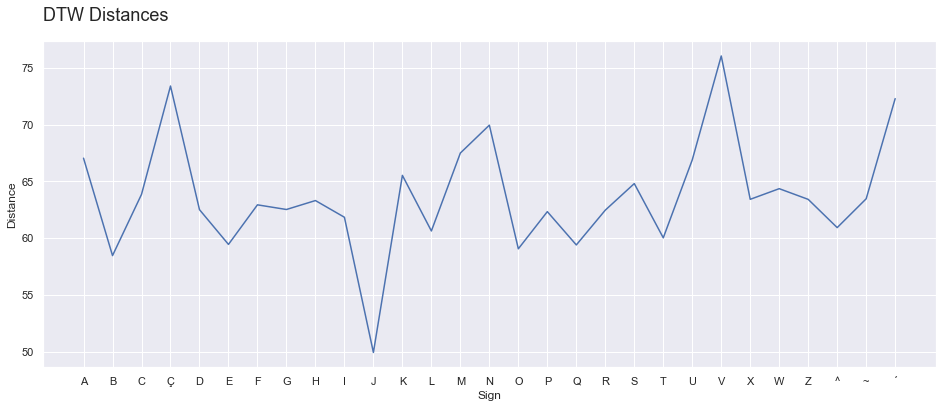

In [147]:
fig = plt.figure(figsize=(16,6))
plt.title('DTW Distances', size=18, pad=20, loc='left')
plt.xlabel('Sign')
plt.ylabel('Distance')
sns.lineplot(predictions.keys(), predictions.values());

Get the lowest value from predictions

In [152]:
min(predictions, key=predictions.get)

'J'

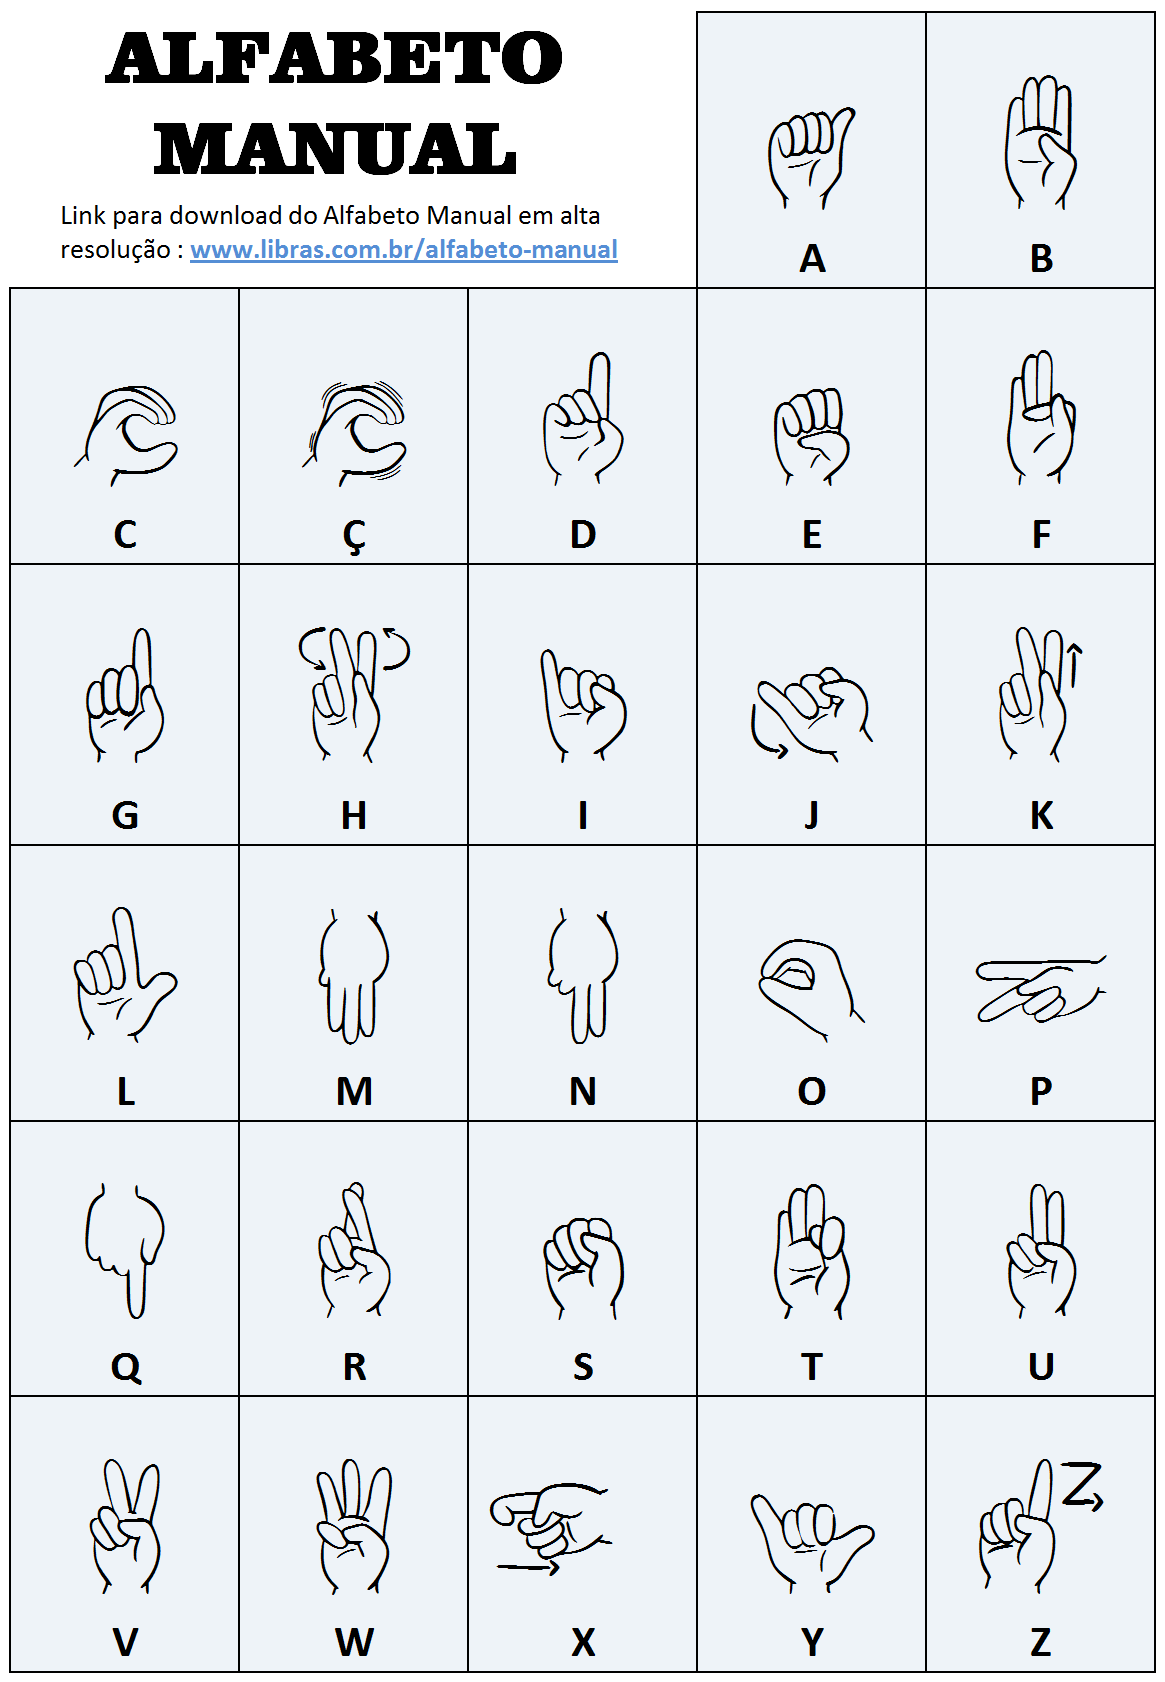

In [39]:
Image('https://www.libras.com.br/images/artigos/alfabeto-manual/alfabeto-manual.png', width=600, height=600)